<a href="https://colab.research.google.com/github/tashir0605/NLU_Assignment/blob/main/NLU_Q_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First few entries from the dataset:
                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0

Initial shape of dataset: (2225, 2)

Shape after filtering: (928, 2)

Label distribution:
Label
1    511
0    417
Name: count, dtype: int64


/tmp/ipython-input-2252008875.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x="Category", palette="viridis")


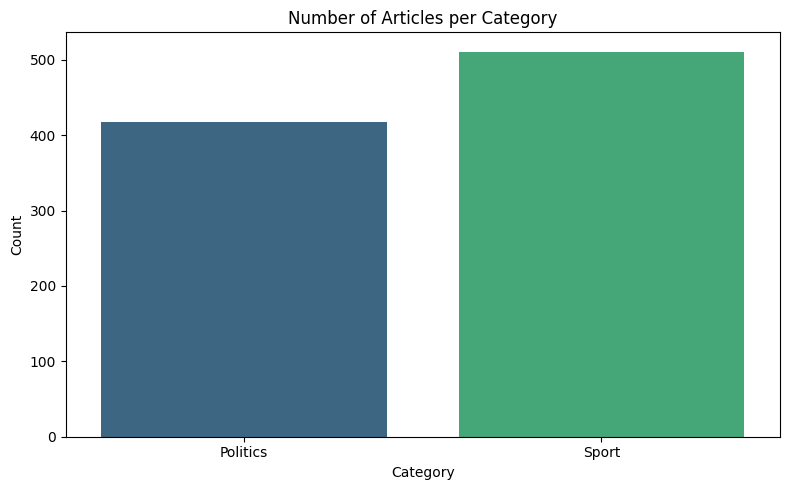

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV file
data_path = "df_file.csv"
df = pd.read_csv(data_path)

print("First few entries from the dataset:")
print(df.head())
print("\nInitial shape of dataset:", df.shape)

# Extracting Only Politics (0) and Sport (1)
filtered_df = df[df["Label"].isin([0, 1])].copy()

# Index Resetting
filtered_df = filtered_df.reset_index(drop=True)

print("\nShape after filtering:", filtered_df.shape)
print("\nLabel distribution:")
print(filtered_df["Label"].value_counts())

# Add readable category names for plotting
filtered_df["Category"] = filtered_df["Label"].map({
    0: "Politics",
    1: "Sport"
})

plt.figure(figsize=(8, 5))
sns.countplot(data=filtered_df, x="Category", palette="viridis")
plt.title("Number of Articles per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [17]:
df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [3]:
filtered_df.describe()

,Label
count,928.000000
mean,0.550647
std,0.497697
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      928 non-null    object
 1   Label     928 non-null    int64 
 2   Category  928 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+", "", text)

    # Keep only letters and spaces
    text = re.sub(r"[^a-z\s]", "", text)

    tokens = nltk.word_tokenize(text)

    cleaned = []
    for word in tokens:
        if word not in stop_words and len(word) > 2:
            cleaned.append(lemmatizer.lemmatize(word))

    return " ".join(cleaned)

print("Cleaning text data...")
filtered_df["CleanedText"] = filtered_df["Text"].apply(clean_text)

print("\nSample comparison:")
print("Before:", filtered_df["Text"].iloc[0][:60])
print("After :", filtered_df["CleanedText"].iloc[0][:60])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Cleaning text data...

Sample comparison:
Before: Budget to set scene for election
 
 Gordon Brown will seek t
After : budget set scene election gordon brown seek put economy cent


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = filtered_df["CleanedText"]
y = filtered_df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=5,
    ngram_range=(1, 2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Training matrix shape:", X_train_vec.shape)
print("Testing matrix shape :", X_test_vec.shape)


Training matrix shape: (742, 3000)
Testing matrix shape : (186, 3000)


In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

svm_model = SVC(kernel="linear", C=1.0, random_state=42)

# Train model
svm_model.fit(X_train_vec, y_train)

# Predict
predictions = svm_model.predict(X_test_vec)

print("----- Validation Results -----")
print("Accuracy:", round(accuracy_score(y_test, predictions), 4))
print("\nDetailed Report:\n")
print(classification_report(y_test, predictions))

# Cross-validation
X_full_vec = vectorizer.fit_transform(X)
cv_results = cross_val_score(svm_model, X_full_vec, y, cv=5)

print("\n----- 5-Fold Cross Validation -----")
print("Scores:", cv_results)
print("Average Accuracy:", round(cv_results.mean(), 4))


----- Validation Results -----
Accuracy: 0.9946

Detailed Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       0.99      1.00      1.00       107

    accuracy                           0.99       186
   macro avg       1.00      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186


----- 5-Fold Cross Validation -----
Scores: [0.98924731 1.         0.98924731 1.         1.        ]
Average Accuracy: 0.9957


In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

models_to_test = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

comparison_results = []
# Create a dictionary to store the TRAINED models for later use
models = {}

print("----- Comparing Models -----")

for model_name, model_instance in models_to_test.items():

    model_instance.fit(X_train_vec, y_train)
    preds = model_instance.predict(X_test_vec)

    acc_value = accuracy_score(y_test, preds)

    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, preds))

    comparison_results.append({
        "Model": model_name,
        "Accuracy": acc_value
    })
    # Store the trained model instance
    models[model_name] = model_instance


comparison_results.append({
    "Model": "Linear SVM",
    "Accuracy": 0.9946
})
models["Linear SVM"] = svm_model # Storing the trained SVM model

final_table = pd.DataFrame(comparison_results)
final_table = final_table.sort_values(by="Accuracy", ascending=False)

print("\nFinal Comparison:")
print(final_table)

----- Comparing Models -----

Multinomial Naive Bayes Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       107

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.98      1.00      0.99       107

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186


Final Comparison:
                     Model  Accuracy
0  Multinomial Naive Bayes  1.000000
2               Linear SVM  0.994600
1      Logistic Regression  0.989247


In [9]:
import numpy as np

# Retrieve vocabulary from vectorizer
vocab = vectorizer.get_feature_names_out()

# Access trained Naive Bayes model
nb_model = models["Multinomial Naive Bayes"]

# Sort indices based on log probabilities
sport_indices = np.argsort(nb_model.feature_log_prob_[1])[::-1]
politics_indices = np.argsort(nb_model.feature_log_prob_[0])[::-1]

print("Top words strongly associated with SPORT:")
print(vocab[sport_indices[:20]])

print("\nTop words strongly associated with POLITICS:")
print(vocab[politics_indices[:20]])

Top words strongly associated with SPORT:
['germany' 'said many' 'police said' 'wilson' 'entirely' 'coach' 'matthew'
 'worker' 'five' 'champion league' 'police' 'teammate' 'cut' 'year'
 'launched' 'simple' 'secretary jack' 'secret' 'coach andy' 'january']

Top words strongly associated with POLITICS:
['said many' 'landed' 'past' 'employment' 'blair told' 'worst' 'gregory'
 'tory say' 'minute second' 'brown would' 'personal' 'tax cut' 'loss'
 'pledged' 'science' 'ian' 'professional' 'professor' 'qualified'
 'chancellor gordon']


In [10]:
vocab = vectorizer.get_feature_names_out()

print("minister" in vocab)
print("parliament" in vocab)
print("prime" in vocab)
print("government" in vocab)


True
True
True
True


/tmp/ipython-input-3110669352.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  accuracy_plot = sns.barplot(


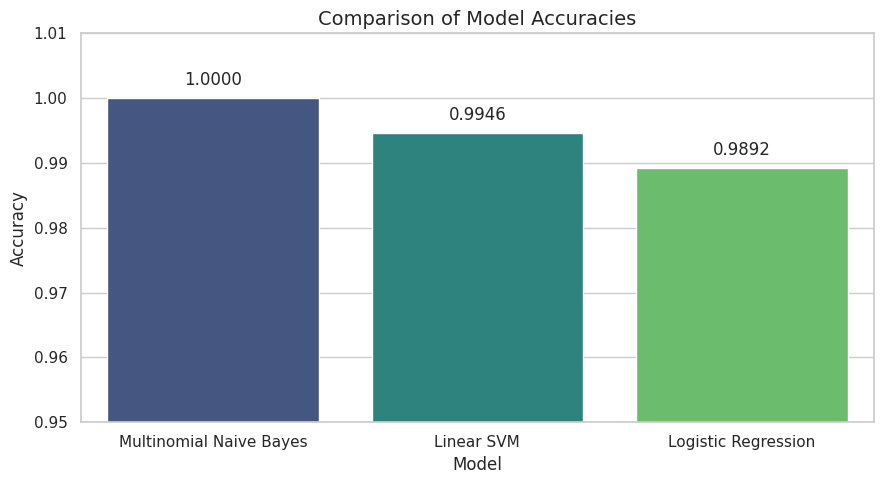

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_theme(style="whitegrid")

# ---- Accuracy Comparison ----
plt.figure(figsize=(9, 5))

accuracy_plot = sns.barplot(
    data=final_table,
    x="Model",
    y="Accuracy",
    palette="viridis"
)

plt.title("Comparison of Model Accuracies", fontsize=14)
plt.ylim(0.95, 1.01)
plt.xlabel("Model")
plt.ylabel("Accuracy")

# Display values above bars
for bar in accuracy_plot.patches:
    value = bar.get_height()
    accuracy_plot.text(
        bar.get_x() + bar.get_width() / 2,
        value + 0.002,
        f"{value:.4f}",
        ha="center"
    )

plt.tight_layout()
plt.show()
# plot_top_features(tfidf, models['Support Vector Machine (SVM)'])

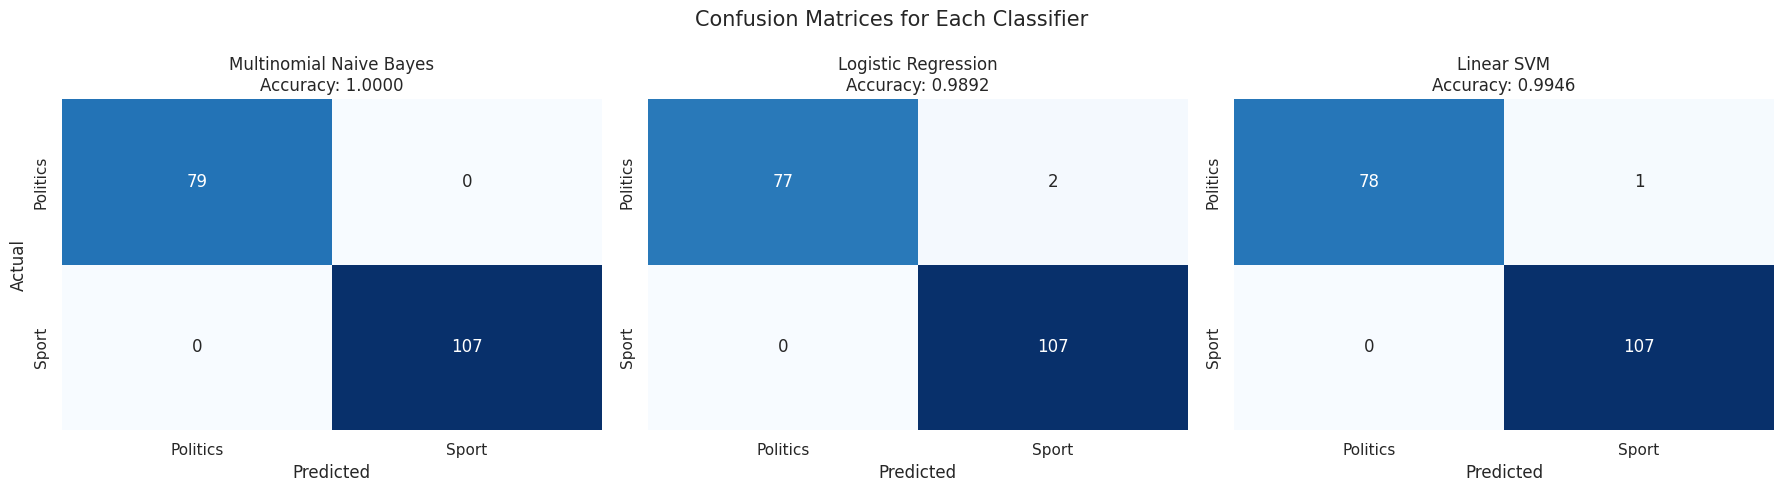

In [14]:
# # ---- Confusion Matrices ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Confusion Matrices for Each Classifier", fontsize=15)

for idx, (model_name, model_instance) in enumerate(models.items()):

    predictions = model_instance.predict(X_test_vec)
    matrix = confusion_matrix(y_test, predictions)

    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[idx],
        xticklabels=["Politics", "Sport"],
        yticklabels=["Politics", "Sport"],
        cbar=False
    )

    acc_value = final_table.loc[
        final_table["Model"] == model_name, "Accuracy"
    ].values[0]

    axes[idx].set_title(f"{model_name}\nAccuracy: {acc_value:.4f}")
    axes[idx].set_xlabel("Predicted")

    if idx == 0:
        axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()
